In [ ]:
import freetype
import numpy as np

face = freetype.Face("Poppins-Light.ttf")

face.set_pixel_sizes(0, 32) 

print(f"Family name: {face.family_name}")
print(f"Style name: {face.style_name}")
print(f"Number of glyphs: {face.num_glyphs}")

Family name: b'Poppins'
Style name: b'Light'
Number of glyphs: 1059


In [ ]:
face.load_char('S', freetype.FT_LOAD_NO_BITMAP)
outline = face.glyph.outline

print(f"Character: 'S'")
print(f"Number of contours: {len(outline.contours)}")
print(f"Number of points: {len(outline.points)}")

for i, point in enumerate(outline.points):
    x, y = point
    tag = outline.tags[i]
    on_curve = (tag & 1) != 0
    point_type = "ON" if on_curve else "OFF (control point)"
    print(f"Point {i}: ({x}, {y}) - {point_type}")

for i, contour_end in enumerate(outline.contours):
    print(f"Contour {i} ends at point {contour_end}")

Character: 'S'
Number of contours: 1
Number of points: 45
Point 0: (473, 0) - OFF (control point)
Point 1: (254, 100) - OFF (control point)
Point 2: (128, 279) - OFF (control point)
Point 3: (128, 389) - ON
Point 4: (267, 389) - ON
Point 5: (277, 285) - OFF (control point)
Point 6: (449, 127) - OFF (control point)
Point 7: (614, 127) - ON
Point 8: (765, 127) - OFF (control point)
Point 9: (943, 277) - OFF (control point)
Point 10: (943, 392) - ON
Point 11: (943, 484) - OFF (control point)
Point 12: (846, 597) - OFF (control point)
Point 13: (701, 652) - OFF (control point)
Point 14: (574, 685) - ON
Point 15: (426, 724) - OFF (control point)
Point 16: (251, 799) - OFF (control point)
Point 17: (128, 955) - OFF (control point)
Point 18: (128, 1088) - ON
Point 19: (128, 1198) - OFF (control point)
Point 20: (247, 1373) - OFF (control point)
Point 21: (462, 1472) - OFF (control point)
Point 22: (601, 1472) - ON
Point 23: (805, 1472) - OFF (control point)
Point 24: (1056, 1275) - OFF (contr

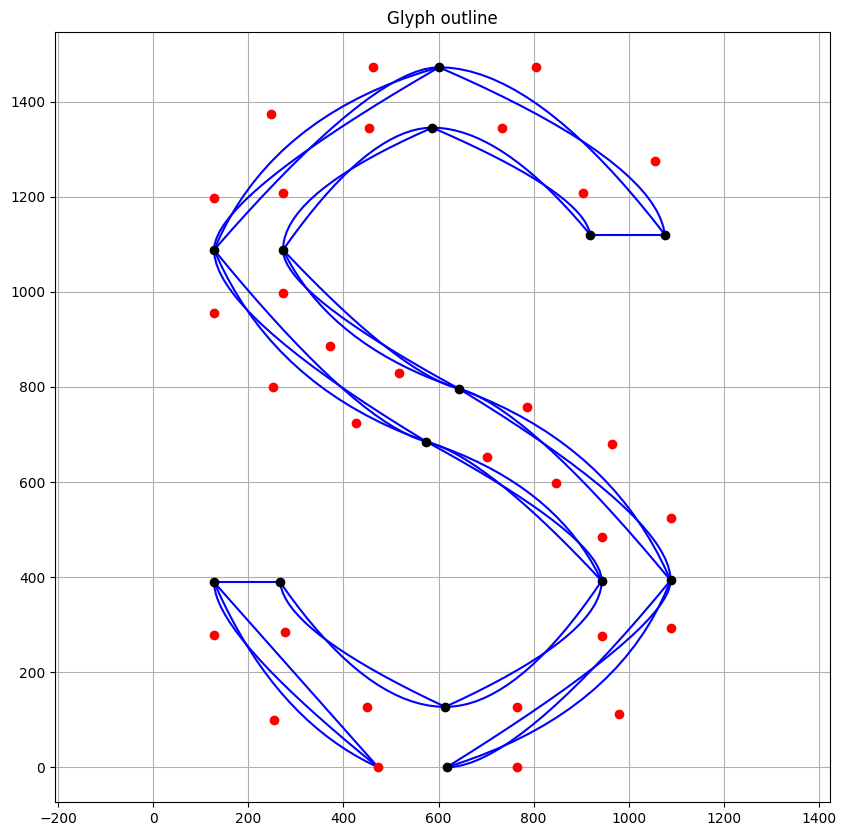

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def extract_bezier_paths(outline):
    
    paths = []
    start = 0
    
    for end in outline.contours:
        points = outline.points[start:end+1]
        tags = outline.tags[start:end+1]
        
        if np.any(points[0] != points[-1]):
            points = np.vstack([points, points[0]])
            tags = np.append(tags, tags[0])
        
        segments = []
        i = 0
        while i < len(points) - 1:
            current_tag = tags[i] & 1  
            next_tag = tags[(i + 1) % len(tags)] & 1
            
            if current_tag:  
                if next_tag:
                    segments.append(('LINE', points[i], points[i+1]))
                    i += 1
                else:  
                    j = i + 1
                    while j < len(points) - 1 and not (tags[j] & 1):
                        j += 1
                    
                    control_points = points[i+1:j]
                    
                    if j < len(points) and (tags[j] & 1):  
                        segments.append(('BEZIER', points[i], control_points, points[j]))
                    else:  
                        implicit_point = (points[j-1] + points[j % len(points)]) / 2
                        segments.append(('BEZIER', points[i], control_points, implicit_point))
                    
                    i = j
            else:  
                
                prev = i - 1
                while prev >= 0 and not (tags[prev] & 1):
                    prev -= 1
                
                if prev < 0:  
                    prev_point = (points[-1] + points[0]) / 2
                else:
                    prev_point = points[prev]
                
                j = i + 1
                while j < len(points) and not (tags[j] & 1):
                    j += 1
                
                if j >= len(points): 
                    next_point = (points[-1] + points[0]) / 2
                else:
                    next_point = points[j]
                
                segments.append(('BEZIER', prev_point, [points[i]], next_point))
                i += 1
        
        paths.append(segments)
        start = end + 1
    
    return paths

def evaluate_quadratic_bezier(p0, p1, p2, t):
    return (1-t)**2 * p0 + 2*(1-t)*t * p1 + t**2 * p2

def plot_glyph(outline, bezier_samples=20):
    paths = extract_bezier_paths(outline)
    
    plt.figure(figsize=(10, 10))
    
    colors = ['blue', 'green', 'purple', 'orange', 'cyan']
    
    for path_idx, segments in enumerate(paths):
        path_color = colors[path_idx % len(colors)]
        
        for segment_type, *data in segments:
            if segment_type == 'LINE':
                p0, p1 = data
                plt.plot([p0[0], p1[0]], [p0[1], p1[1]], color=path_color)
            elif segment_type == 'BEZIER':
                p0, control_points, p2 = data
                for p1 in control_points:
                    t_values = np.linspace(0, 1, bezier_samples)
                    curve_points = np.array([evaluate_quadratic_bezier(p0, p1, p2, t) for t in t_values])
                    plt.plot(curve_points[:, 0], curve_points[:, 1], color=path_color)
    
    
    for i, (point, tag) in enumerate(zip(outline.points, outline.tags)):
        if tag & 1:  
            plt.plot(point[0], point[1], 'ko')
        else: 
            plt.plot(point[0], point[1], 'ro')
    
    plt.gca()
    plt.axis('equal')
    plt.grid(True)
    plt.title(f"Glyph outline")
    
    return plt

face.load_char('S', freetype.FT_LOAD_NO_BITMAP)
outline = face.glyph.outline
plot_glyph(outline)
plt.show()

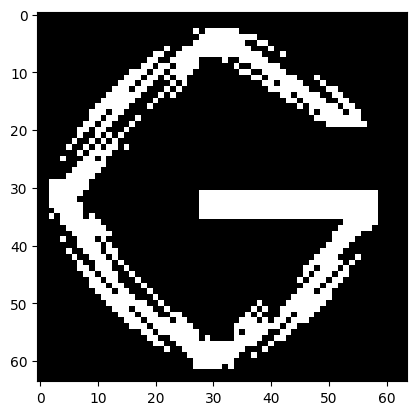

In [ ]:
def rasterize_glyph(outline, width, height, scale=1.0):

    bitmap = np.zeros((height, width), dtype=np.uint8)
    
    paths = extract_bezier_paths(outline)
    edges = []
    
    for segments in paths:
        polyline_points = []
        for segment_type, *data in segments:
            if segment_type == 'LINE':
                p0, p1 = data
                polyline_points.append(p0)
            elif segment_type == 'BEZIER':
                p0, control_points, p2 = data
                polyline_points.append(p0)
                for p1 in control_points:
                    t_values = np.linspace(0, 1, 20)[1:] 
                    curve_points = np.array([evaluate_quadratic_bezier(p0, p1, p2, t) for t in t_values])
                    polyline_points.extend(curve_points)
        
        for i in range(len(polyline_points) - 1):
            edges.append((polyline_points[i], polyline_points[i+1]))
    
    glyph_min_x = min(min(p[0] for p, _ in edges), min(p[0] for _, p in edges))
    glyph_max_x = max(max(p[0] for p, _ in edges), max(p[0] for _, p in edges))
    glyph_min_y = min(min(p[1] for p, _ in edges), min(p[1] for _, p in edges))
    glyph_max_y = max(max(p[1] for p, _ in edges), max(p[1] for _, p in edges))
    
    glyph_width = glyph_max_x - glyph_min_x
    glyph_height = glyph_max_y - glyph_min_y
    
    scale_x = (width - 4) / glyph_width * scale
    scale_y = (height - 4) / glyph_height * scale
    scale_factor = min(scale_x, scale_y)
    
    for y in range(height):
       
        font_y = glyph_max_y - (y / scale_factor - 2 / scale_factor)
        
        intersections = []
        for (p0, p1) in edges:
            if (p0[1] <= font_y < p1[1]) or (p1[1] <= font_y < p0[1]):
                if p1[1] - p0[1] != 0:  
                    x = p0[0] + (p1[0] - p0[0]) * (font_y - p0[1]) / (p1[1] - p0[1])
                    scaled_x = int((x - glyph_min_x) * scale_factor + 2)
                    if 0 <= scaled_x < width:  
                        intersections.append(scaled_x)
        
        intersections.sort()
        
        for i in range(0, len(intersections), 2):
            if i + 1 < len(intersections):
                start = max(0, intersections[i])
                end = min(width, intersections[i+1])
                bitmap[y, start:end] = 255
    
    return bitmap

face.load_char('F', freetype.FT_LOAD_NO_BITMAP)
outline = face.glyph.outline
bitmap = rasterize_glyph(outline, 64, 64)
plt.imshow(bitmap, cmap='gray')
plt.show()